# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *

### Base path ###
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
spot_name = 'p3verde100s'
path_input = path_shared + 'dataXRDXRF/CappellaBrancacci/SpotXRD/'
path_spot = path_input + spot_name + '/'

file_xrd         = path_spot + 'Frame0001.dat'   # XRD scan
file_calibration_xrd = path_input + 'calibration.ini'
file_xrf = path_spot + spot_name + '.spe'    # XRF scan

list_path_database = [path_shared + 'Database16_42/']   # tabulated phases

### Output ###
subfolder_output = 'SpotResults/' + spot_name + '/'
path_figures = subfolder_output + 'figures/'            # figures generated by the script
path_database_exp = subfolder_output + 'databaseEXP/'   # experimental phases
path_calibrations = subfolder_output + 'calibrations/'  # calibrated XRD spectra
path_peaks = subfolder_output + 'peaks/'                # peaks automatically found in experimental XRD pattern

paths_to_create_delete = [subfolder_output, path_figures, path_database_exp, path_calibrations, path_peaks]

### Fit ###
sigma = 0.20             # sigma used in the peaks of synthetic diffraction patterns
min_theta = 17
max_theta = 45
min_intensity = None     # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None     # selects the first n most intense peaks (if None, leaves all the peaks)
distance_merge = sigma   # Distance under which peaks are merged in each phase. Put None to avoid merging.

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False
if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database16_42/'
Total number of phases: 364


# Read and process XRD data

Loading '../../shared/dataXRDXRF/CappellaBrancacci/SpotXRD/p3verde100s/Frame0001.dat'
Data length: 1280
Initial calibration:
a = -71.8, s = 2253.7, beta = 16.997
Theta range [15.17321393 45.17384068]


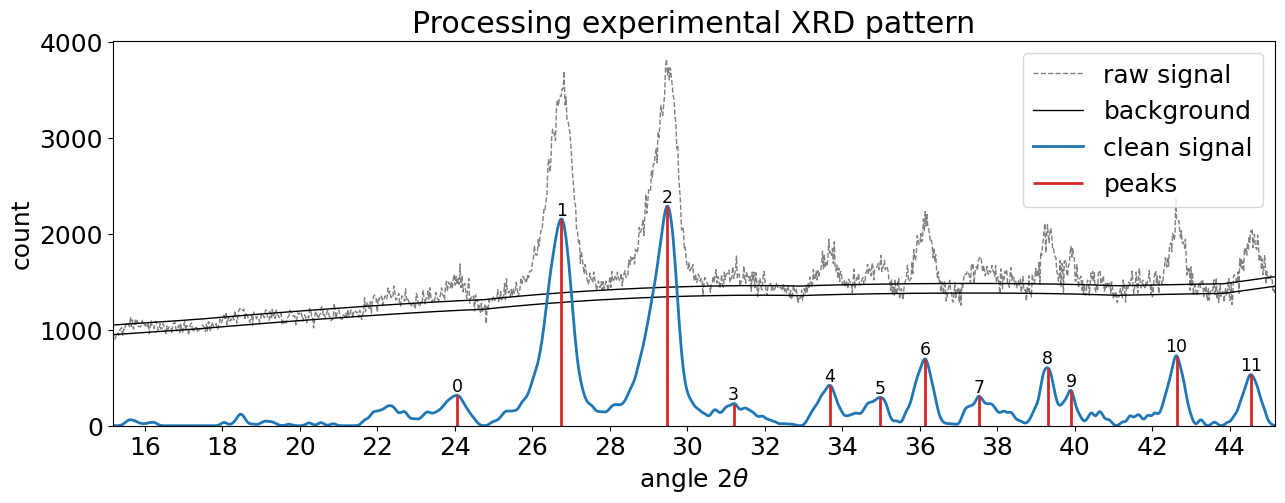

,Angle,Intensity
0,24.060,0.138
1,26.747,0.941
2,29.488,1.000
3,31.196,0.101
4,33.676,0.184
5,34.973,0.129
6,36.139,0.304
7,37.533,0.134
8,39.296,0.264
9,39.902,0.161


In [5]:
rcParams['font.size'] = 18

### Parameters for smoothing ###
window_snip = 60        # width of the window used for determining the background (default 32)
offset_background = 100   # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3          # degree of the final smooth applied to the XRD pattern (default 0)

### Parameters for searching peaks ###
width_peak = 5   # Minimum width of the peaks, in channels (default 10)
height_peak = 0.13  # Minimum height of the peaks, between 0 and 1, compared against a logarithmic function of the XRD pattern

###

print(f'Loading \'{file_xrd}\'')
spectrum_xrd = (
    FastSpectraXRD()
    .from_file(file_xrd)
    .calibrate_from_file(file_calibration_xrd)
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_kernel = std_smooth)
)
print(f'Data length: {spectrum_xrd.counts.shape[0]}')
print('Initial calibration:')
print(f'a = {spectrum_xrd.opt[0]:.1f}, s = {spectrum_xrd.opt[1]:.1f}, beta = {spectrum_xrd.opt[2]:.3f}')
print(f'Theta range {spectrum_xrd.theta_range()}')

signal_for_peaks = log(spectrum_xrd.intensity + 1)
signal_for_peaks /= signal_for_peaks.max()
peaks_position = find_peaks(signal_for_peaks, width = width_peak, height = height_peak)[0]
peaks_position_angle = spectrum_xrd.fce_calibration(peaks_position, *spectrum_xrd.opt)
peaks_intensity = spectrum_xrd.intensity[peaks_position]

arr_to_write = concatenate((peaks_position_angle[:, newaxis], peaks_intensity[:, newaxis]), axis = 1)
savetxt(f'{path_peaks}xrd peaks with initial calibration.dat', arr_to_write, '%.3f %.3f')

arr_to_write = concatenate((spectrum_xrd.theta[:, newaxis], spectrum_xrd.counts[:, newaxis]), axis = 1)
savetxt(f'{path_calibrations}xrd raw with initial calibration.dat', arr_to_write, '%.3f %i')

arr_to_write = concatenate((spectrum_xrd.theta[:, newaxis], spectrum_xrd.counts_smoothed[:, newaxis]), axis = 1)
savetxt(f'{path_calibrations}xrd smoothed and no-bg with initial calibration.dat', arr_to_write, '%.3f %i')

fig, ax = subplots(figsize = (15, 5))
ax.plot(spectrum_xrd.theta, spectrum_xrd.counts, c = 'grey', ls = '--', lw = 1, label = 'raw signal')
ax.plot(spectrum_xrd.theta, spectrum_xrd.background, c = 'black', ls = '-', lw = 1, label = 'background')
ax.plot(spectrum_xrd.theta, spectrum_xrd.background + spectrum_xrd.offset_background, c = 'black', ls = '-', lw = 1)
ax.plot(spectrum_xrd.theta, spectrum_xrd.counts_smoothed, lw = 2, label = 'clean signal')
ax.vlines(peaks_position_angle, 0, spectrum_xrd.counts_smoothed[peaks_position], color = 'tab:red', lw = 2, label = 'peaks')
for i in range(len(peaks_position_angle)):
    text(peaks_position_angle[i], spectrum_xrd.counts_smoothed[peaks_position[i]], f'{i}', ha = 'center', va = 'bottom', fontsize = 'x-small')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xticks(arange(0, spectrum_xrd.theta_range()[1] + 0.001, 2))
ax.set_xlim(*spectrum_xrd.theta_range())
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('count')
ax.set_title('Processing experimental XRD pattern')
show()

(DataFrame({'Angle': peaks_position_angle, 'Intensity': peaks_intensity})
 .style.format({'Angle': '{:.3f}', 'Intensity': '{:.3f}'}))

# Read XRF spectrum

- <code>file_calibration_xrf</code>: File with calibration for xrf data. Use <code>None</code> to avoid calibration.
- <code>limits_x_nocalibration</code> and <code>limits_x_calibration</code>: Limits for plotting horizontal axis. The first ones are used when the spectrum is left without calibration; the second ones are used when the spectrum is calibrated. Use <code>[None, None]</code> to leave default limits.
- <code>log_scale_y</code>: Whether to use log scale for vertical axis.

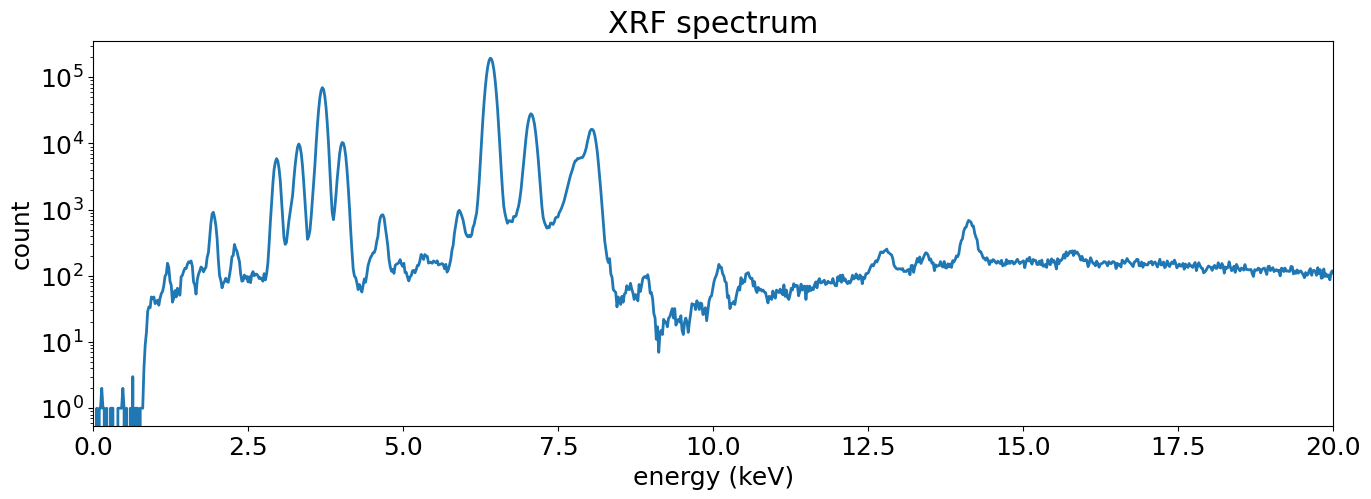

In [8]:
file_calibration_xrf = path_input + 'calib_XRF_2nd.calib'
#file_calibration_xrf = None

limits_x_nocalibration = [None, None]   # x limits when the spectrum is left without calibration
limits_x_calibration = [0, 20]          # x limits when the spectrum is calibrated

log_scale_y = True

###

spectrum_xrf = SpectraXRF().from_spe(file_xrf)
if (file_calibration_xrf is not None):
    parameters = read_parameters_calibration_xrf(file_calibration_xrf)
    spectrum_xrf.calibrate_from_parameters(parameters)
    x = spectrum_xrf.energy
    x_limits = limits_x_calibration
    x_label = 'energy (keV)'
else:
    x = spectrum_xrf.channel
    x_limits = limits_x_nocalibration
    x_label = 'channel'

fig, ax = subplots(figsize = (16, 5))
ax.plot(x, spectrum_xrf.counts, lw = 2, label = 'raw signal')
if log_scale_y:
    ax.set_yscale('log')

ax.set_xlim(*x_limits)
ax.set_xlabel(x_label)
ax.set_ylabel('count')
ax.set_title('XRF spectrum')
show()

# Choose elements

### View samples of a given phase
View samples with peaks in all the given angular ranges.

In [11]:
phase_with_multiple_samples = database['Calcite'] # Here you need to select a phase without specifying the sample

#list_ranges_theta = [ [20.86, 20.87], [26.65, 26.66] ]
list_ranges_theta = [ [29.4, 29.5] ]

###

list_sample, list_theta, list_intensity = [], [], []
for i, phase in enumerate(phase_with_multiple_samples):
    thetas, intensities, _ = phase.get_theta()
    if all(any(range_theta[0] <= theta <= range_theta[1] for theta in thetas) for range_theta in list_ranges_theta):
        for theta, intensity in zip(thetas, intensities):
            if any(range_theta[0] <= theta <= range_theta[1] for range_theta in list_ranges_theta):
                list_sample.append(i)
                list_theta.append(theta)
                list_intensity.append(intensity)
(DataFrame({'Sample index': list_sample, 'Angle of peak': list_theta, 'Intensity of peak': list_intensity})
 .style.format({'Angle of peak': '{:.3f}', 'Intensity of peak': '{:.3f}'}))

,Sample index,Angle of peak,Intensity of peak
0,0,29.423,1.000
1,2,29.430,1.000
2,9,29.420,1.000
3,10,29.424,1.000
4,11,29.415,1.000
5,12,29.411,1.000
6,24,29.416,1.000
7,31,29.417,1.000
8,36,29.462,1.000


### View phases of chosen elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.
- `list_ranges_theta`: Only phases with peaks in all the given angular ranges. Leave as `None` to avoid this selection.

In [12]:
elements_chosen = ['Ca']
elements_excluded = []

### Conditions on peaks ###

list_ranges_theta = [ [29.4, 29.5] ]
#list_ranges_theta = [ [20.86, 20.87], [26.65, 26.66] ]   # To select only phases with peaks in all the given angular ranges
#list_ranges_theta = None                                  # To avoid selecting by angles of the peaks

min_intensity__for_selection = 0.5     # Condition needs to be satisfied by peaks with intensity above the given threshold
first_n_peaks__for_selection = None     # Condition needs to be satisfied by the first n peaks

###

list_samples = []
#df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of compatible samples', 'Filename'])
df_phases = DataFrame()
df_phases['Name in database'] = []
df_phases['Chemical formula'] = []
df_phases['N. of compatible samples'] = []
df_phases['Filename'] = []
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        
        # Change 'all' (the first) into 'any' if you want to select phases that have at least one of elements_chosen
        
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)
           ):
            if list_ranges_theta is not None:
                list_samples_this_phase = [
                    i for i in range(len(phase_set))
                    if all( any(range_theta[0] <= theta <= range_theta[1]
                                for theta in phase_set[i].get_theta(
                                    min_intensity = min_intensity__for_selection, first_n_peaks = first_n_peaks__for_selection
                                )[0]) for range_theta in list_ranges_theta)
                ]
            else:
                list_samples_this_phase = list(range(len(phase_set)))
            n_samples = len(list_samples_this_phase)
            if (n_samples > 0):
                df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], n_samples, basename(p['name'])]
                list_samples.append(list_samples_this_phase)
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of compatible samples,Filename
0,Calcite,C Ca O3,9,Entry_96-900-0096.cif
1,V Basic copper calcium carbonate,Cu Ca C,1,BluBice_range_16-42_0.cif
2,V Calcite,Ca C O3,3,CalciumCarbonate_range_16-42_0.cif


# Check a phase vs XRD pattern
Plots: fit result, measure of the presence and selected peaks.

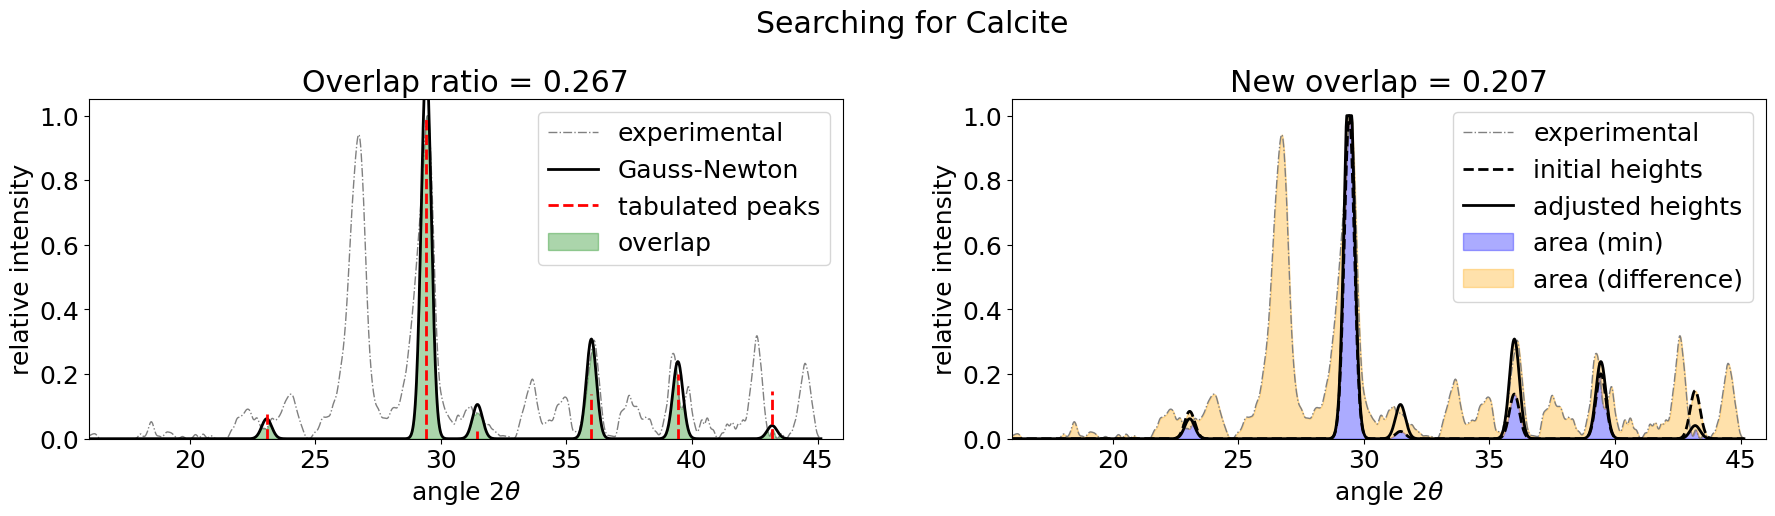

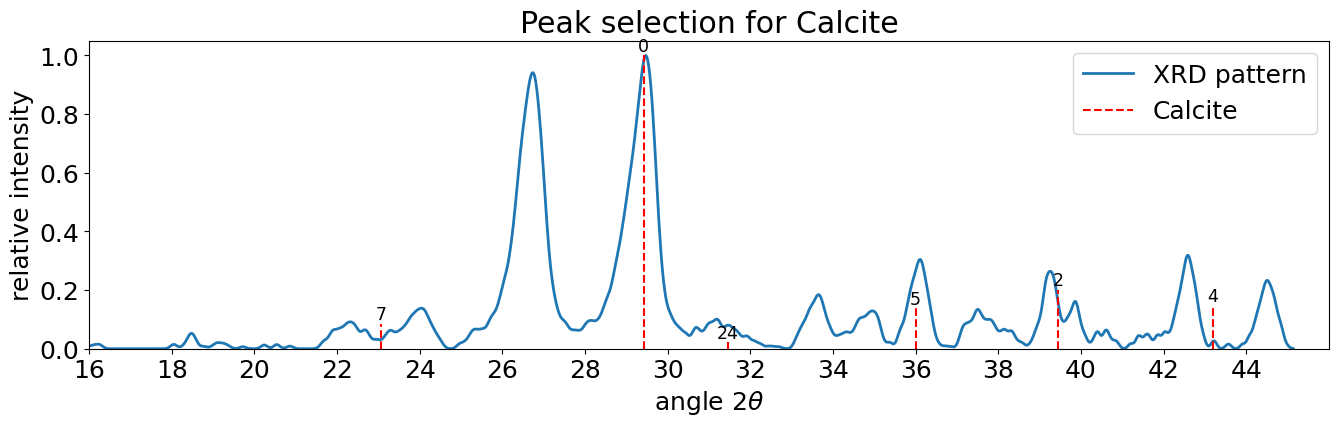

In [13]:
rcParams['font.size'] = 18

### Fit options ###

# Phase that will be checked against the experimental XRD pattern
phase_check = database['Calcite'][0]   # V Fe2O3, 1

# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted by fitting phase_calibration on the experimental XRD pattern.
adjust_calibration = True
#phase_calibration = database['Akaganeite'][0]
phase_calibration = phase_check

###

gn = GaussNewton(phase_check, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gn.opt = gn_calibration.opt

gn.fit_cycle(gamma = True, steps = 32)

z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
z = clip(gn.z(), None, 1)
intensity_corrected = maximum(gn.intensity, 0)
z_stack = stack((z0, z, intensity_corrected))
z_min = z_stack.min(axis = 0)
z_max = z_stack.max(axis = 0)
presence = z_min.sum() / z_max.sum()

### Measures of phase presence ###

fig, axs = subplots(1, 2, figsize = (18, 5))
fig.tight_layout(w_pad = 4)
fig.subplots_adjust(top = 0.8)   # To shift the title

ax = axs[0]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

ax = axs[1]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (difference)')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'New overlap = {gn.adjustment_ratio():.3f}')

fig.suptitle(f'Searching for {gn.label}')

show()

### Peak selection ###

fig, ax = subplots(figsize = (16, 4))
sca(ax)
ax.plot(gn.theta, gn.intensity, lw = 2, label = 'XRD pattern')
gn.plot_phase(positions = True)
ax.legend(frameon = True, loc = 'upper right')
ax.set_xticks(arange(0, gn.theta_range()[1] + 0.001, 2))
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Peak selection for {gn.label}')
show()

### Select peaks

In [14]:
#database['Calcite'][0].select_peaks([0, 4])
database['Calcite'][0].select_peaks()
None

# Reduce list of phases

### Fit selected phases on experimental XRD pattern

In [15]:
### How to measure phase presence ###
phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True)           # vecchio metodo
# ('overlap_area_ratio', False)    # vecchio metodo, altro modo di realizzarlo
# ('adjustment_ratio', False)      # nuovo metodo

### Calibration ###
adjust_calibration = True


###


list_presence = []
list_presence_avg = []
list_presence_max = []
list_x_y = []

for i in range(df_phases.shape[0]):
    phase_name = df_phases['Name in database'].iloc[i]
    phase_set = database[phase_name]

    gs = GammaSearch([phase_set[j] for j in list_samples[i]], spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    if adjust_calibration:
        gs = gs.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gs = gs.fit_cycle(gamma = True, steps = 32)
    presence = gs.phase_presence(method = phase_presence_method, correction = phase_presence_correction)
    list_presence.append(presence)

df_phases['Best sample'] = [list_samples[i][nanargmax(presence)] for i, presence in enumerate(list_presence)]
df_phases['Best presence'] = [nanmax(presence) for presence in list_presence]
(df_phases
 .sort_values(by = ['Best presence'], ascending = False)
 .reset_index(drop = True)
 .style.format({'Best presence': '{:.3f}'}))

,Name in database,Chemical formula,N. of compatible samples,Filename,Best sample,Best presence
0,V Basic copper calcium carbonate,Cu Ca C,1,BluBice_range_16-42_0.cif,1,0.254
1,Calcite,C Ca O3,9,Entry_96-900-0096.cif,10,0.207
2,V Calcite,Ca C O3,3,CalciumCarbonate_range_16-42_0.cif,0,0.207


### Select phase samples
If the presence of a phase is above `threshold_presence`, the phase is selected.

In [16]:
threshold_presence = 0.2

###

df_phases_sel = (
    df_phases.loc[df_phases['Best presence'] >= threshold_presence]
    .rename(columns = {'Name in database': 'Phase', 'Chemical formula': 'Formula', 'Best sample': 'Sample', 'Best presence': 'Presence'})
    [['Phase', 'Formula', 'Sample', 'Presence']]
)
df_phases_sel = df_phases_sel.sort_values(by = ['Presence'], ascending = False).reset_index(drop = True)
df_phases_sel.style.format({'Presence': '{:.3f}'})

,Phase,Formula,Sample,Presence
0,V Basic copper calcium carbonate,Cu Ca C,1,0.254
1,Calcite,C Ca O3,10,0.207
2,V Calcite,Ca C O3,0,0.207


# Check the fit of listed phases

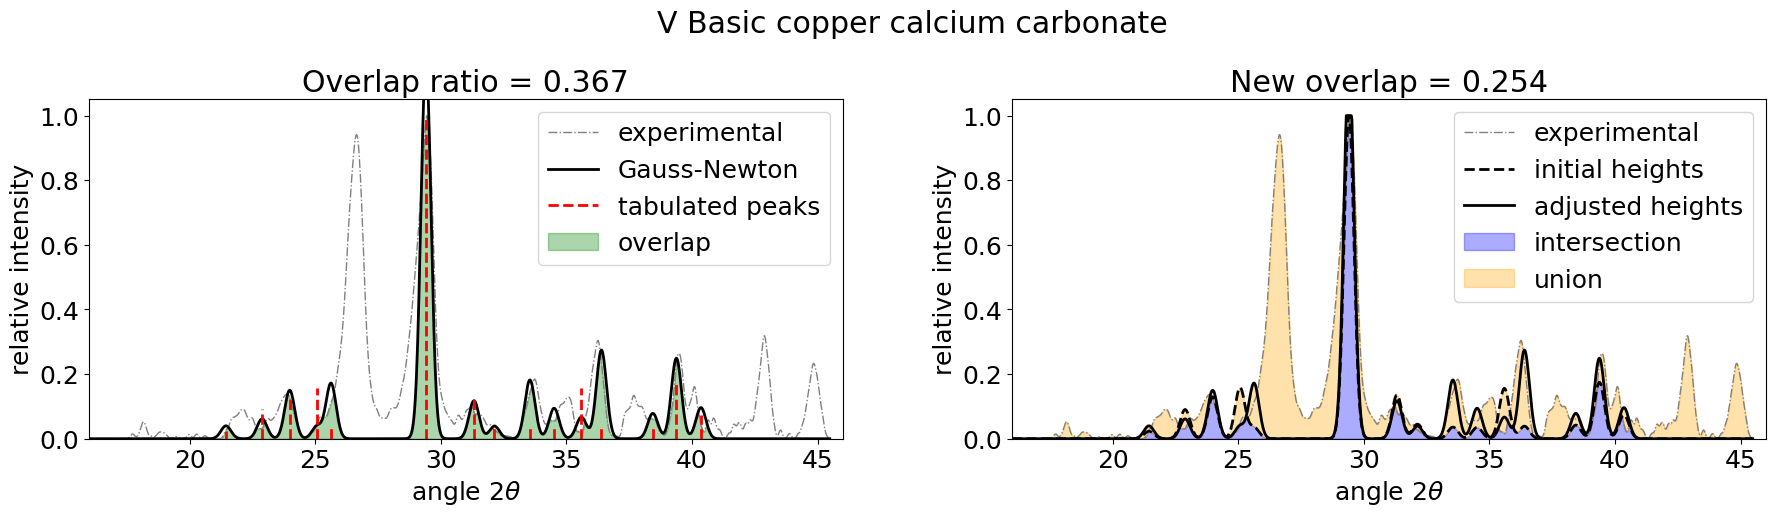

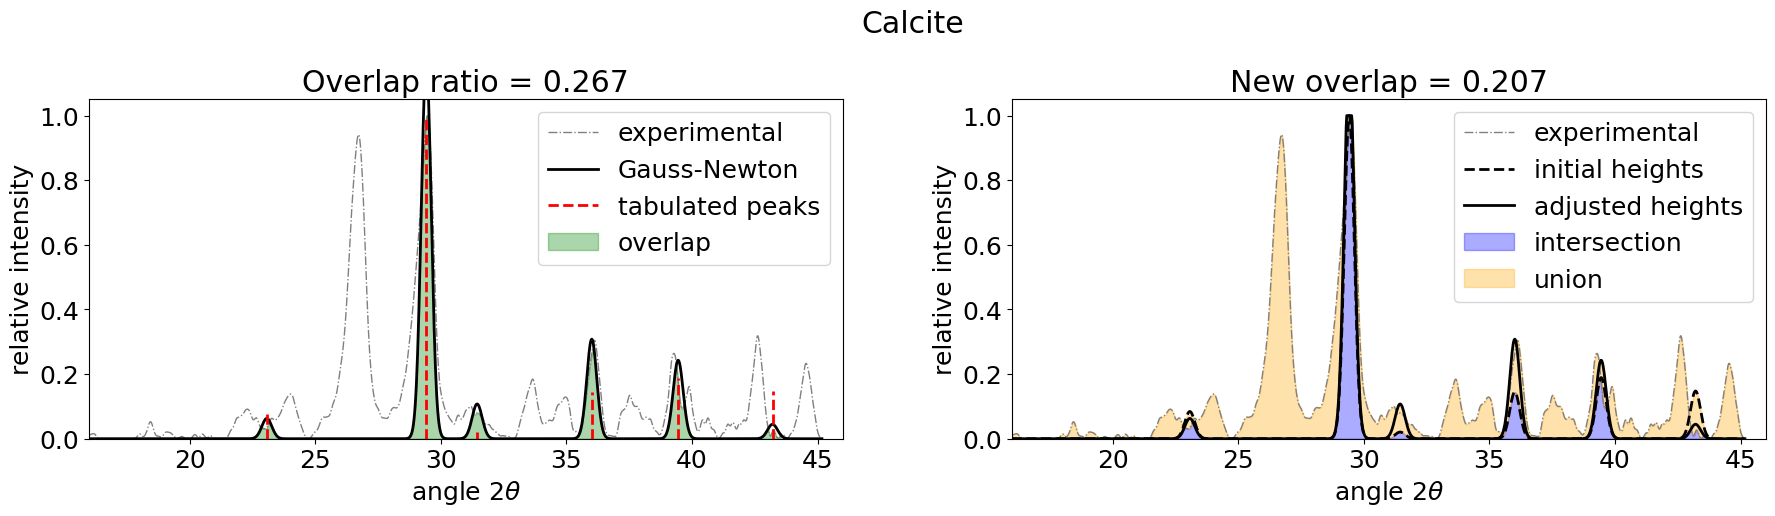

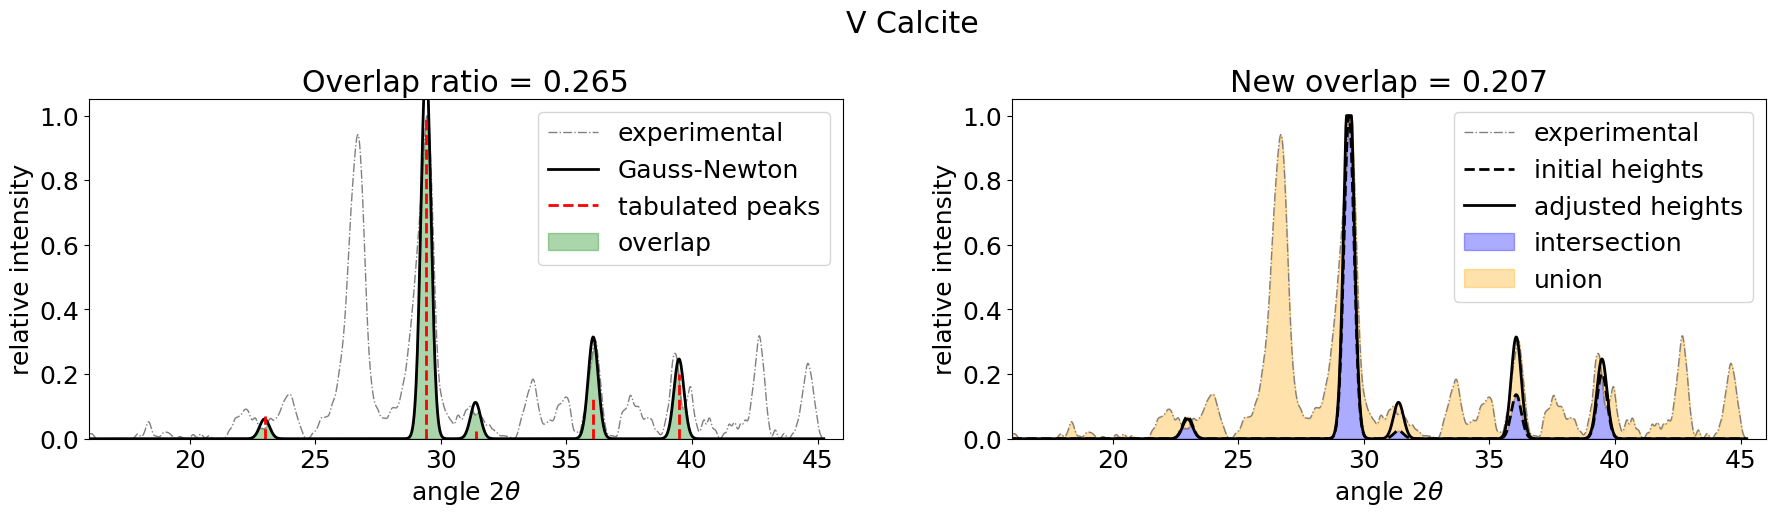

In [17]:
rcParams['font.size'] = 18

### Calibration parameters ###
# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted depending on the value of 'phase_calibration'.
# If phase_calibration is set to a specific phase, the calibration with that phase will be used for the exploration of all the phases.
# If phase_calibration is set to None, each phase is calibrated on experimental XRD pattern.
adjust_calibration = True
#phase_calibration = database['Lazurite'][0]
phase_calibration = None

###

list_phases_check = []
for i in range(df_phases_sel.shape[0]):
    phase_name = df_phases_sel.loc[i, 'Phase']
    phase_sample = df_phases_sel.loc[i, 'Sample']
    phase = database[phase_name][phase_sample]
    list_phases_check.append(phase)

gs = GammaSearch(list_phases_check, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)

for gn in gs:
    
    ### Fit ###
    phase_check = gn.phase


    if adjust_calibration:
        if phase_calibration is None:
            p = phase_check
        else:
            p = phase_calibration
        gn_calibration = GaussNewton(p, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
        gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
        gn.opt = gn_calibration.opt

        arr_to_write = concatenate((gn.theta[:, newaxis], gn.spectrum.counts[:, newaxis]), axis = 1)
        savetxt(f'{path_calibrations}xrd raw calibrated with {clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %d')
        arr_to_write = concatenate((gn.theta[:, newaxis], gn.spectrum.counts_smoothed[:, newaxis]), axis = 1)
        savetxt(f'{path_calibrations}xrd smoothed calibrated with {clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %.3f')

        arr_to_write = concatenate(
            (gn.fce_calibration(peaks_position, *gn.opt)[:, newaxis],
             peaks_intensity[:, newaxis]),
            axis = 1
        )
        savetxt(f'{path_peaks}xrd peaks calibrated with {clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %.3f')

    gn.fit_cycle(gamma = True, steps = 32)

    z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
    z = clip(gn.z(), None, 1)
    intensity_corrected = maximum(gn.intensity, 0)
    z_stack = stack((z0, z, intensity_corrected))
    z_min = z_stack.min(axis = 0)
    z_max = z_stack.max(axis = 0)
    presence = z_min.sum() / z_max.sum()

    ### Plot ###

    fig, axs = subplots(1, 2, figsize = (18, 5))
    fig.tight_layout(w_pad = 4)
    fig.subplots_adjust(top = 0.8)   # To shift the title

    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

    ax = axs[1]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
    ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'intersection')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'union')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'New overlap = {gn.adjustment_ratio():.3f}')

    fig.suptitle(gn.label)

    savefig(f'{path_figures}{clean_phase_name(gn.label)} - check fit.png', bbox_inches = 'tight', dpi = 300)
    show()
    close(fig)

# Check the fit of an ensemble of phases

### Select phases and check their ensemble

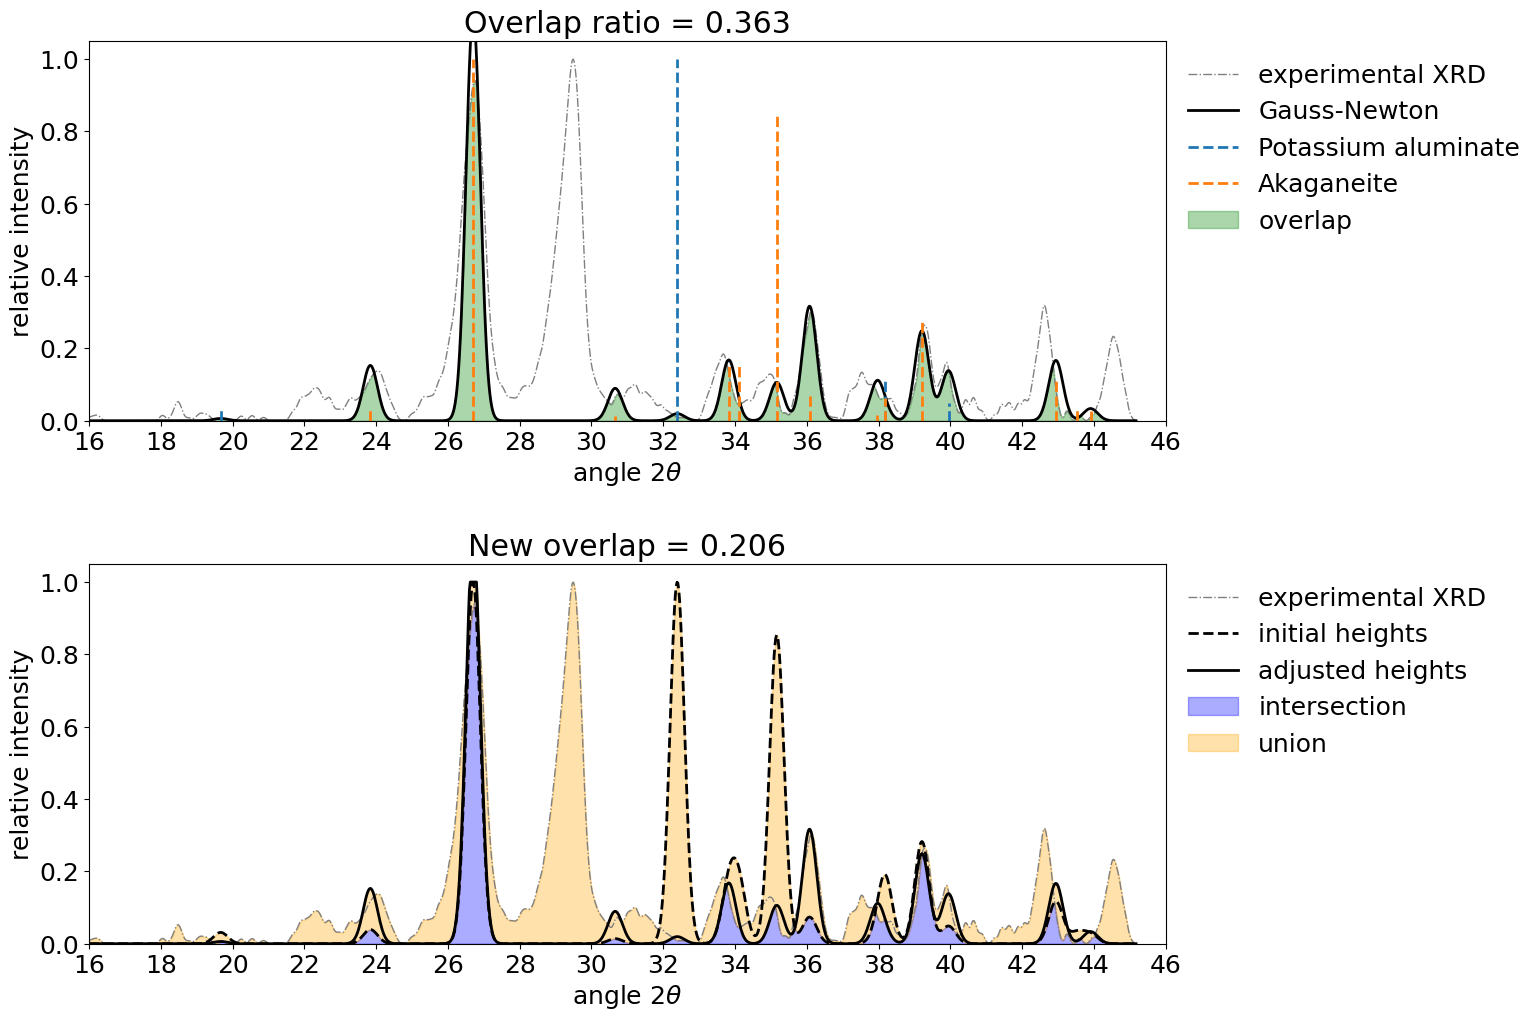

In [19]:
rcParams['font.size'] = 18

### Phase selection ###
phase_check = PhaseList([database['Potassium aluminate'][0], database['Akaganeite'][0]])

adjust_calibration = False
#phase_calibration = database['Cerussite'][1]
phase_calibration = phase_check

###

gn = GaussNewton(phase_check, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gn.opt = gn_calibration.opt
gn.fit_cycle(gamma = True, steps = 32)

z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
z = clip(gn.z(), None, 1)
intensity_corrected = maximum(gn.intensity, 0)
z_stack = stack((z0, z, intensity_corrected))
z_min = z_stack.min(axis = 0)
z_max = z_stack.max(axis = 0)
presence = z_min.sum() / z_max.sum()

### Plot ###

fig, axs = subplots(2, 1, figsize = (12, 10))
fig.tight_layout(h_pad = 4)

ax = axs[0]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental XRD')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.plot_phase(lw = 2)
ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = False, bbox_to_anchor = (1, 1), loc = 'upper left')
ax.set_xticks(arange(0, max_theta + 1.001, 2))
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

ax = axs[1]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental XRD')
ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'intersection')
ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'union')
ax.legend(frameon = False, bbox_to_anchor = (1, 1), loc = 'upper left')
ax.set_xticks(arange(0, max_theta + 1.001, 2))
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'New overlap = {gn.adjustment_ratio():.3f}')

savefig(f'{path_figures}{clean_phase_name(gn.label)} - check fit.png', bbox_inches = 'tight', dpi = 300)
show()
close(fig)

# Select phases and save them

### Review list of phases

In [16]:
df_phases_sel.style.format({'Presence': '{:.3f}'})

,Phase,Formula,Sample,Presence
0,V Basic copper calcium carbonate,Cu Ca C,0,0.254
1,Calcite,C Ca O3,3,0.207
2,V CalciumCarbonate,Ca C O3,0,0.207


### Select phases to save
Leave empty list to select all phases.

In [23]:
list_names_phase = ['V Fe2O3', 'Potassium Iron Sulfate Hydroxide']
#list_names_phase = []   # leave empty list to select all phases

### Delete file with list of selected phases
Delete the files `phases_selection.dat`.

In [24]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    filename = f'{subfolder_output}phases_selection.dat'
    if exists(filename):
        remove(filename)

### Write file with list of selected phases

This cell writes the list of names of selected phases into the file `phases_selection.dat`. If the file does not exist, the cell creates it.

In [25]:
if len(list_names_phase) > 0:
    df_phases_sel_2 = df_phases_sel[df_phases_sel['Phase'].isin(list_names_phase)]
else:
    df_phases_sel_2 = df_phases_sel

filename = f'{subfolder_output}phases_selection.dat'
df_phases_sel_2.to_csv(filename, header = False, index = False, mode = 'a', float_format = '%.3f')

### Save experimental phases

In [26]:
for gn in gs:
    if ( (len(list_names_phase) == 0) or (gn.label in list_names_phase) ):
        phase_exp = gn.make_phase()
        filename = path_database_exp + clean_phase_name(gn.label) + '.cif'
        print(filename)
        phase_exp.save_cif(filename)

SpotResults/p3verde100s/databaseEXP/V Fe2O3.cif
SpotResults/p3verde100s/databaseEXP/Potassium Iron Sulfate Hydroxide.cif
